In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [14]:
data=pd.read_csv('Chicago_listings.csv')
data_cleaned = data.copy()
data_cleaned['price'] = data_cleaned['price'].replace('[\$,]', '', regex=True).astype(float)
data_cleaned['host_response_rate'] = data_cleaned['host_response_rate'].astype(str).fillna('').str.replace('%', '').replace('', np.nan).astype(float)
data_cleaned['host_acceptance_rate'] = data_cleaned['host_acceptance_rate'].astype(str).fillna('').str.replace('%', '').replace('', np.nan).astype(float)
data_cleaned['host_is_superhost'] = data_cleaned['host_is_superhost'].map({'t': 1, 'f': 0})
data_cleaned['instant_bookable'] = data_cleaned['instant_bookable'].map({'t': 1, 'f': 0})
num_cols = ['bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews', 'availability_365']
data_cleaned[num_cols] = data_cleaned[num_cols].fillna(data_cleaned[num_cols].median())
data_cleaned = data_cleaned.dropna(subset=['price'])

                       id                                       listing_url  \
0                16757056             https://www.airbnb.com/rooms/16757056   
1                48112045             https://www.airbnb.com/rooms/48112045   
2     1089958767588000931  https://www.airbnb.com/rooms/1089958767588000931   
3                24694181             https://www.airbnb.com/rooms/24694181   
4      639920368906600737   https://www.airbnb.com/rooms/639920368906600737   
...                   ...                                               ...   
7947  1000697794721640829  https://www.airbnb.com/rooms/1000697794721640829   
7948   737600228577337279   https://www.airbnb.com/rooms/737600228577337279   
7949   866318429557340926   https://www.airbnb.com/rooms/866318429557340926   
7950             51198174             https://www.airbnb.com/rooms/51198174   
7951   678998149626085566   https://www.airbnb.com/rooms/678998149626085566   

           scrape_id last_scraped       source  \
0

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


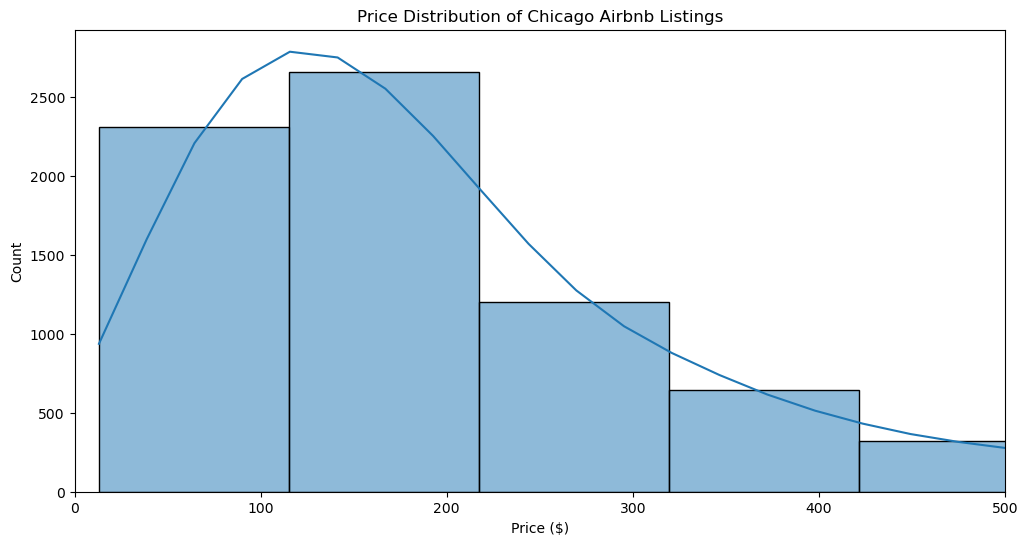

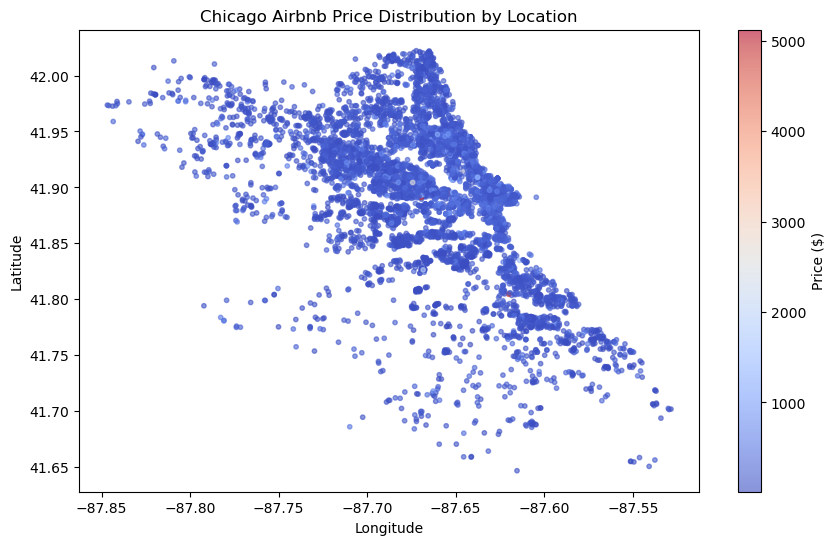

In [15]:
### Exploratory Data Analysis (EDA)
plt.figure(figsize=(12,6))
sns.histplot(data_cleaned['price'], bins=50, kde=True)
plt.xlim(0, 500)
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.title("Price Distribution of Chicago Airbnb Listings")
plt.show()

plt.figure(figsize=(10, 6))
sc = plt.scatter(data_cleaned["longitude"], data_cleaned["latitude"], c=data_cleaned["price"], cmap="coolwarm", alpha=0.6, s=10)
cbar = plt.colorbar(sc)
cbar.set_label("Price ($)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Chicago Airbnb Price Distribution by Location")
plt.show()

In [16]:
##Feature Engineering

target = 'price'
features = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 
            'review_scores_rating', 'number_of_reviews', 'availability_365', 
            'latitude', 'longitude', 'host_is_superhost', 'instant_bookable']

X = data_cleaned[features]
y = data_cleaned[target]

X = X.fillna(X.median())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Model Performance:\nRMSE: {rmse:.2f}\nR² Score: {r2:.2f}")

Random Forest Model Performance:
RMSE: 156.09
R² Score: 0.66


In [19]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test_scaled)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Tuned Random Forest Model Performance:\nRMSE: {rmse:.2f}\nR² Score: {r2:.2f}")
print("Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuned Random Forest Model Performance:
RMSE: 151.47
R² Score: 0.68
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   4.8s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   5.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=2, min_sampl

In [22]:
!pip install xgboost
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)

In [23]:
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost Model Performance:\nRMSE: {rmse_xgb:.2f}\nR² Score: {r2_xgb:.2f}")


XGBoost Model Performance:
RMSE: 176.29
R² Score: 0.57


In [25]:
high_price_threshold = data_cleaned['price'].median() 
high_price_listings = data_cleaned[data_cleaned['price'] > high_price_threshold]


high_price_summary = high_price_listings[features].mean()
print(high_price_summary)

low_price_listings = data_cleaned[data_cleaned['price'] < high_price_threshold]
low_price_summary = low_price_listings[features].mean()
print(low_price_summary)


accommodates              5.716847
bedrooms                  2.251516
beds                      2.791722
bathrooms                 1.674005
review_scores_rating      4.802331
number_of_reviews        44.600580
availability_365        226.293435
latitude                 41.894913
longitude               -87.653759
host_is_superhost         0.477267
instant_bookable          0.428948
dtype: float64
accommodates              3.159852
bedrooms                  1.352150
beds                      1.522553
bathrooms                 1.183197
review_scores_rating      4.756138
number_of_reviews        62.411501
availability_365        205.069111
latitude                 41.889621
longitude               -87.670572
host_is_superhost         0.448482
instant_bookable          0.304669
dtype: float64
